# CS535/EE514 - Spring 2025 - Assignment 4 - Neural Network from Scratch

## Marks: 100
## Due Date: April 29, 2025, 23:55

## Instructions

*   Submit your code both as notebook file (.ipynb) and python script (.py) on LMS. The name of both files should be 'RollNo_PA04'.

*   The code MUST be implemented independently. Any plagiarism or cheating of work from others or the internet will be immediately referred to the DC.

* 10% penalty per day for 3 days after due date. No submissions will be accepted after  that.

* Use procedural programming style and comment your code properly.

* **Deadline to submit this assignment is April 29, 2025, 23:55**

* Make sure to run all blocks before submission.

### Goal:

The goal of this assignment is to give hands on experience of basic python tools and libraries to implement a custom neural network from scratch.

### Note:

You are <font color="red">not allowed </font> to use any other libraries than the ones imported below for this assignment. You will be performing binary classification and regression using your custom neural network on some simple synthetic datasets. Then you will preform multiclass classification using FashionMNIST.



<b>
Name: Farooq Ahmad

Roll Number: 24030021
</b>

## Required Imports

In [ ]:
import numpy as np
import pandas as pd
# from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import time
from sklearn.datasets import make_regression

%matplotlib inline

SEED = 42 # set random seed to 42

## Section 1: Coding the NeuralNetwork Class (from scratch)

### Instructions:
In this task, you will be implementing a neural network from scratch using numpy. The skeleton of the neural network class is provided to you. You only need to write the parts that are incomplete/empty.

*Forward/backward pass & Weight Update:* Implement the forward and backward pass algorithms. Try to vectorize your code as much as possible, relying on numpy functions instead of for loops.

*Optimizers:*
Full-batch Gradient Descent has been implemented for you. You need to implement minibatch and stochastic gradient descent variants.

Both weights and biases will be initialized to all zeroes.

**Visualization code** is provided to plot the learnt decision boundary of your model.


*Activation Functions:* You will implement the following activation functions (note that forward and backward pass will need to be adjusted according to the choice of the activation function):
- Sigmoid
- ReLU
- Leaky ReLU (leaky slope is fixed at 0.05)
- Tanh

In [ ]:
# Helper function to plot a decision boundary. You don't need to understand this.

def plot_decision_boundary(pred_func, x_min, x_max, y_min, y_max, cmap, ax):
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.flatten(), yy.flatten()])
    Z = Z.reshape(xx.shape)
    # Plot the contour
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)

In [ ]:
class NeuralNetwork():
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        eps = 1e-15  # avoid log(0)
        y_pred = np.clip(y_pred, eps, 1 - eps)
        if y_true.ndim == 1:
            correct_probs = y_pred[np.arange(len(y_true)), y_true]
        else:
            correct_probs = (y_pred * y_true).sum(axis=1)
        return -np.mean(np.log(correct_probs))

    @staticmethod
    def mean_squared_loss(y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)

    @staticmethod
    def accuracy(y_pred, y_true):
        pred_labels = np.argmax(y_pred, axis=1)
        return np.mean(pred_labels == y_true)

    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def ReLU(x):
        return np.maximum(0, x)

    def Leaky_ReLU(self, x):
        return np.where(x > 0, x, self.leaky_slope * x)

    def Tanh(self, x):
        return np.tanh(x)

    def __init__(self, nodes_per_layer: list[int], mode: str = 'classification', optimizer: str = 'fullbatch', activation: str = 'sigmoid', batch_size: int = 64):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing the number of nodes in each layer (including the input layer) e.g. [2, 10, 10, 2] (2 features, 2 hidden layers with 10 neurons each, 2 classes)"
        '''

        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have at least 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('The number of nodes in all layers must be positive.')

        assert mode.lower() in ['classification', 'regression'], "Only classification and regression modes are supported"
        assert optimizer.lower() in ['sgd', 'minibatch', 'fullbatch'], 'Unknown Optimizer'
        assert activation.lower() in ['sigmoid', 'relu', 'leaky_relu','tanh'], 'Unknown activation function'

        self.num_layers = np.size(nodes_per_layer)
        self.mode = mode
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[-1]
        self.optimizer = optimizer
        self.activation_strat = activation
        self.batch_size = batch_size

        if activation == 'leaky_relu':
            self.leaky_slope = 0.05

        # Initialize all weights based on a standard normal distribution and all biases to 0.
        self.weights_ = []
        self.biases_ = []
        self.__init_weights(nodes_per_layer)


    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on a standard normal distribution and all biases to 0.'''
        np.random.seed(SEED)
        for i, _ in enumerate(nodes_per_layer):
            if i == 0:
                # skip the input layer; it does not have weights/bias
                continue

            weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]))
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape=(nodes_per_layer[i],))
            self.biases_.append(bias_vector)




    def fit(self, Xs, Ys, X_val, Y_val, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr".
        Returns list containing loss for each epoch.'''
        self.history = []
        self.val_history = []
        self._run_optimizer(Xs,Ys, X_val, Y_val, epochs, lr)
        return self.history, self.val_history

    def _run_optimizer(self, Xs, Ys, X_val, Y_val, epochs, lr):
        if self.optimizer == 'fullbatch':
            for epoch in tqdm(range(epochs)):
                activations = self.forward_pass(Xs)
                deltas = self.backward_pass(Ys, activations)
                layer_inputs = [Xs] + activations[:-1]
                self.weight_update(deltas, layer_inputs, lr)

                preds = self.predict(Xs)
                current_loss = self.cross_entropy_loss(preds, Ys) if self.mode == 'classification' else self.mean_squared_loss(preds, Ys)
                self.history.append(current_loss)

                preds = self.predict(X_val)
                current_loss = self.cross_entropy_loss(preds, Y_val) if self.mode == 'classification' else self.mean_squared_loss(preds, Y_val)
                self.val_history.append(current_loss)

        elif self.optimizer == 'sgd':
            for epoch in tqdm(range(epochs)):
                idx = np.random.randint(0, Xs.shape[0])
                X_batch = Xs[idx:idx+1]
                Y_batch = Ys[idx:idx+1]

                activations = self.forward_pass(X_batch)
                deltas = self.backward_pass(Y_batch, activations)
                layer_inputs = [X_batch] + activations[:-1]
                self.weight_update(deltas, layer_inputs, lr)

                preds = self.predict(Xs)
                current_loss = self.cross_entropy_loss(preds, Ys) if self.mode == 'classification' else self.mean_squared_loss(preds, Ys)
                self.history.append(current_loss)

                preds = self.predict(X_val)
                current_loss = self.cross_entropy_loss(preds, Y_val) if self.mode == 'classification' else self.mean_squared_loss(preds, Y_val)
                self.val_history.append(current_loss)

        elif self.optimizer == 'minibatch':
            for epoch in tqdm(range(epochs)):
                indices = np.random.permutation(Xs.shape[0])
                Xs_shuffled = Xs[indices]
                Ys_shuffled = Ys[indices]

                for start_idx in range(0, Xs.shape[0], self.batch_size):
                    end_idx = min(start_idx + self.batch_size, Xs.shape[0])
                    X_batch = Xs_shuffled[start_idx:end_idx]
                    Y_batch = Ys_shuffled[start_idx:end_idx]

                    activations = self.forward_pass(X_batch)
                    deltas = self.backward_pass(Y_batch, activations)
                    layer_inputs = [X_batch] + activations[:-1]
                    self.weight_update(deltas, layer_inputs, lr)

                preds = self.predict(Xs)
                current_loss = self.cross_entropy_loss(preds, Ys) if self.mode == 'classification' else self.mean_squared_loss(preds, Ys)
                self.history.append(current_loss)

                preds = self.predict(X_val)
                current_loss = self.cross_entropy_loss(preds, Y_val) if self.mode == 'classification' else self.mean_squared_loss(preds, Y_val)
                self.val_history.append(current_loss)


    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''

        activations = []
        x = input_data

        for i in range(len(self.weights_)):
            z = np.dot(x, self.weights_[i]) + self.biases_[i]

            # Last layer
            if i == len(self.weights_) - 1:
                if self.mode == 'classification':
                    x = self.softmax(z)
                else:
                    x = z  # regression: no activation
            else:
                if self.activation_strat == 'sigmoid':
                    x = self.sigmoid(z)
                elif self.activation_strat == 'relu':
                    x = self.ReLU(z)
                elif self.activation_strat == 'leaky_relu':
                    x = self.Leaky_ReLU(z)
                elif self.activation_strat == 'tanh':
                    x = self.Tanh(z)
            activations.append(x)

        return activations


    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropagation algorithm.
        "targets" is the ground truth/labels.
        "layer_activations" are the return value of the forward pass step.
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course).'''
        deltas = []
        L = len(layer_activations)

        output = layer_activations[-1]

        if self.mode == 'classification':
            if targets.ndim == 1:  # if not already one-hot
                onehot = np.zeros((targets.size, self.output_shape))
                onehot[np.arange(targets.size), targets] = 1
                targets = onehot

            delta = output - targets  # (batch_size, num_classes)

        else:  # regression
            delta = (output - targets)

        deltas.append(delta)

        # Now backpropagate through hidden layers
        for i in reversed(range(L-1)):
            activation = layer_activations[i]

            if self.activation_strat == 'sigmoid':
                grad = activation * (1 - activation)
            elif self.activation_strat == 'relu':
                grad = np.where(activation > 0, 1, 0)
            elif self.activation_strat == 'leaky_relu':
                grad = np.where(activation > 0, 1, self.leaky_slope)
            elif self.activation_strat == 'tanh':
                grad = 1 - activation ** 2

            delta = np.dot(delta, self.weights_[i+1].T) * grad
            deltas.append(delta)

        deltas.reverse()
        return deltas


    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        for i in range(len(self.weights_)):
            grad_w = np.dot(layer_inputs[i].T, deltas[i]) / deltas[i].shape[0]
            grad_b = np.mean(deltas[i], axis=0)

            self.weights_[i] -= lr * grad_w
            self.biases_[i] -= lr * grad_b


    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        return self.forward_pass(Xs)[-1]

    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_loss(pred, Ys)
        elif self.mode == 'classification':
            ce_loss = self.cross_entropy_loss(pred, Ys)
            acc = self.accuracy(pred, Ys)
            return ce_loss, acc

## Section 2: Binary Classification

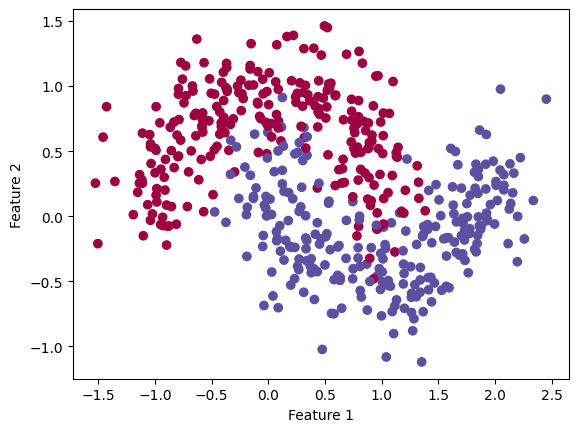

In [ ]:
data_x, data_y = make_moons(500, noise=0.25, random_state=SEED)
plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
plt.gca().set(xlabel='Feature 1', ylabel='Feature 2')
plt.show()

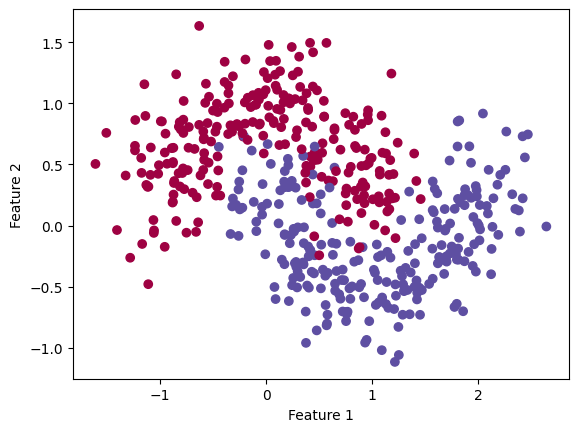

In [ ]:
data_x, data_y = make_moons(500, noise=0.25, random_state=SEED)
plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
plt.gca().set(xlabel='Feature 1', ylabel='Feature 2')
plt.show()

In [ ]:
# doing a 80-20 train-test split
X_train, X_val, Y_train, Y_val = train_test_split(data_x, data_y, test_size = 0.2, random_state=SEED)

- To check your implementation efficiency, we will check the running time of your code.<br>
- Vectorize your implementation to improving your efficency.

<font color="red"> Slow running times will be penalized. </font>

In [ ]:
def plot_losses(train_hist, val_hist):
    '''
    Plots the training and validation loss curves.
    '''
    plt.figure(figsize=(10,6))
    plt.plot(train_hist, label='Training Loss')
    plt.plot(val_hist, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

100%|██████████| 250/250 [00:00<00:00, 270.41it/s]


Runtime of the algorithm is  0.926  seconds


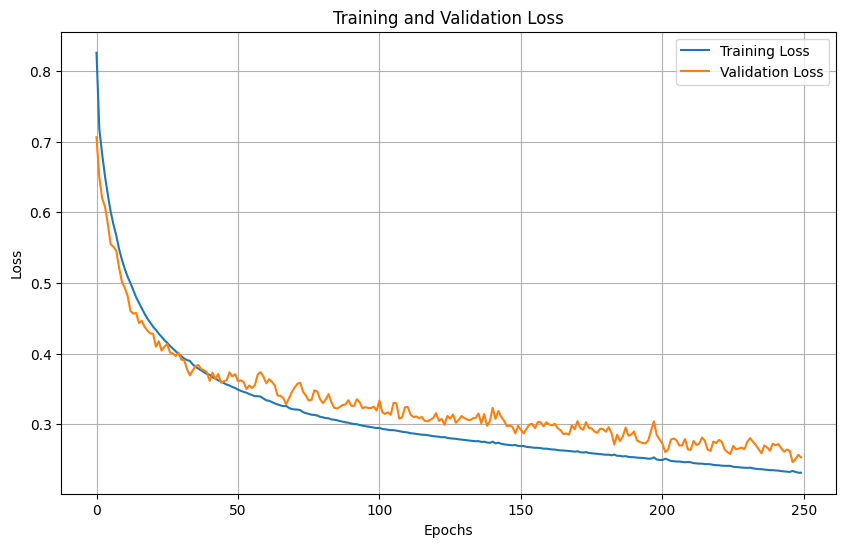

In [ ]:
# PLEASE DO NOT CHANGE THE INPUT AND OUTPUT SIZE OR THE MODE FOR THIS PART
nn = NeuralNetwork([2, 60, 40, 20, 2], mode='classification', activation='sigmoid', optimizer = 'minibatch', batch_size=64)
start = time.time()
history, val_hist = nn.fit(X_train, Y_train, X_val, Y_val, epochs = 250, lr = 0.02)

# end time
end = time.time()
print("Runtime of the algorithm is ",round((end - start),3)," seconds")

# Plot both training and val loss history
plot_losses(history, val_hist)

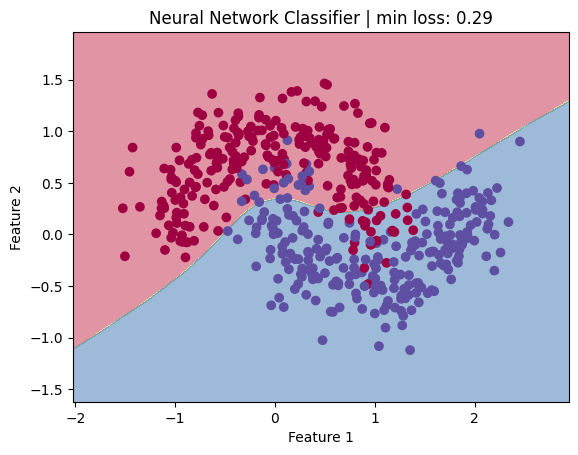

In [ ]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1),
                       x_min, x_max, y_min, y_max,
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier | min loss: {np.min(val_hist):.2f}')
plt.show()

# You should expect a run time of less than 4 seconds

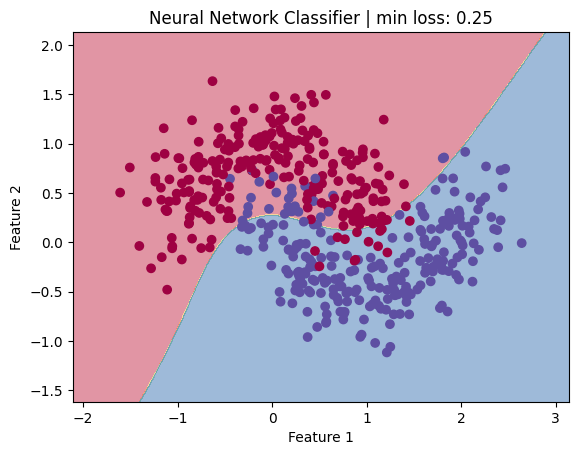

In [ ]:
# Decision Boundary
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1),
                       x_min, x_max, y_min, y_max,
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier | min loss: {np.min(val_hist):.2f}')
plt.show()

Repeat the experiment using the same dataset and hyperparameters, but change only the activation function of the hidden layers. Compare results for sigmoid, ReLU, Leaky ReLU, and tanh to analyze their impact on training dynamics and performance.

Then answer the following:
* How did the network's ability to separate the two moon clusters change with different activations?
* How did the decision boundaries differ for each activation function?
* Which activation suffers the most from overfitting?
* Was there a significant difference in the number of epochs needed to reach optimal performance?

Try to rationalize these observations with what you know about these activation functions.

*Note: I am not looking for exact mathematical reasoning or detailed explanations. Focus on intuition and keep your responses concise.*



Training with activation: sigmoid


100%|██████████| 250/250 [00:00<00:00, 279.71it/s]


Runtime: 0.895s, Min Validation Loss: 0.2464


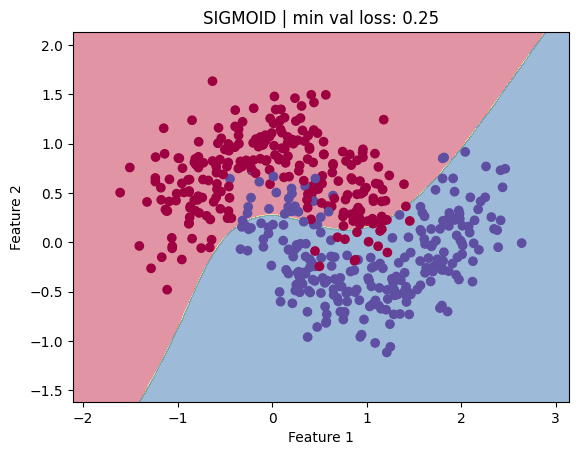

<Figure size 640x480 with 0 Axes>

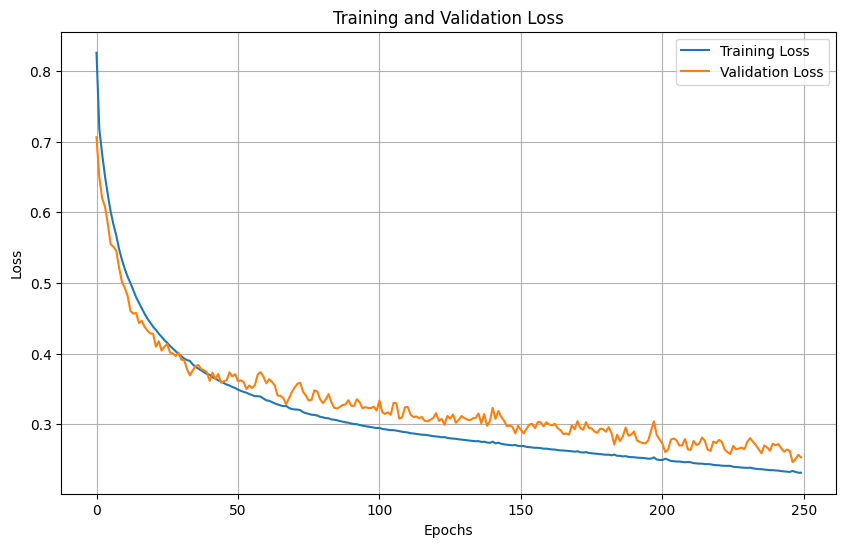


Training with activation: relu


100%|██████████| 250/250 [00:01<00:00, 248.40it/s]


Runtime: 1.024s, Min Validation Loss: 0.1778


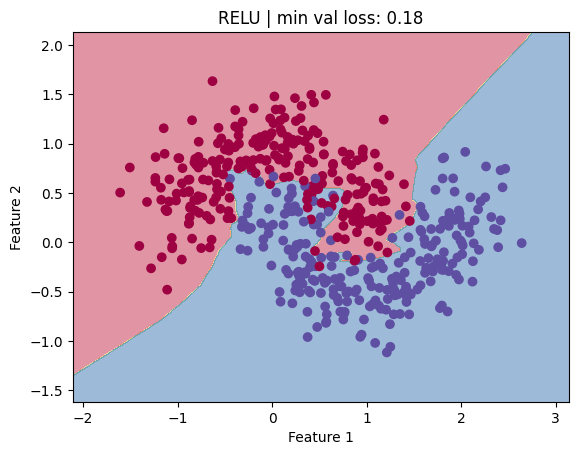

<Figure size 640x480 with 0 Axes>

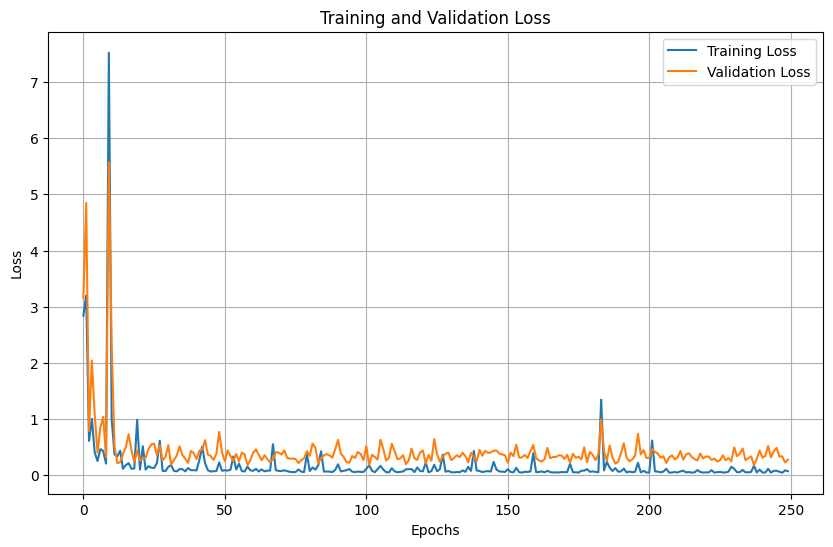


Training with activation: leaky_relu


100%|██████████| 250/250 [00:01<00:00, 232.05it/s]


Runtime: 1.081s, Min Validation Loss: 0.1886


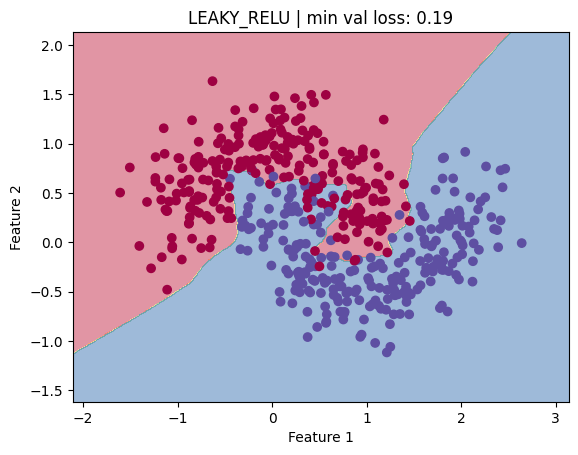

<Figure size 640x480 with 0 Axes>

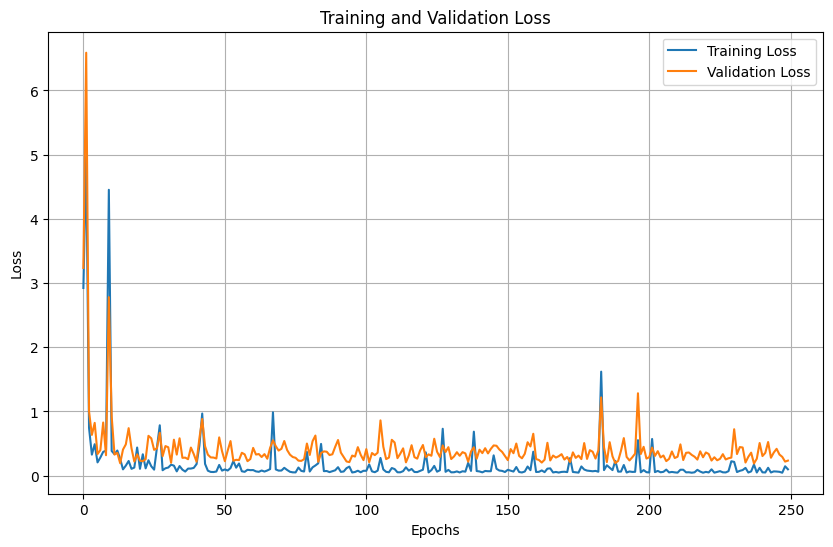


Training with activation: tanh


100%|██████████| 250/250 [00:01<00:00, 208.05it/s]


Runtime: 1.202s, Min Validation Loss: 0.1746


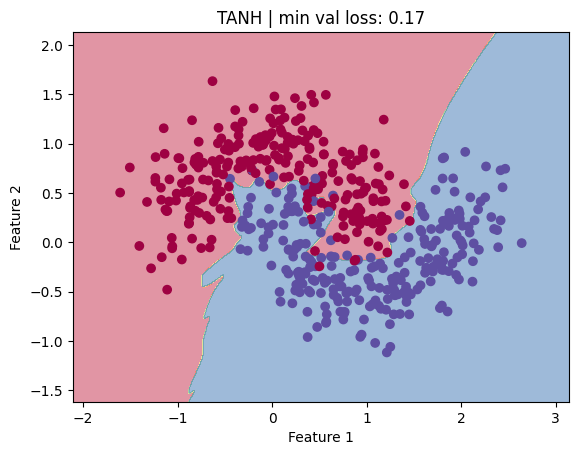

<Figure size 640x480 with 0 Axes>

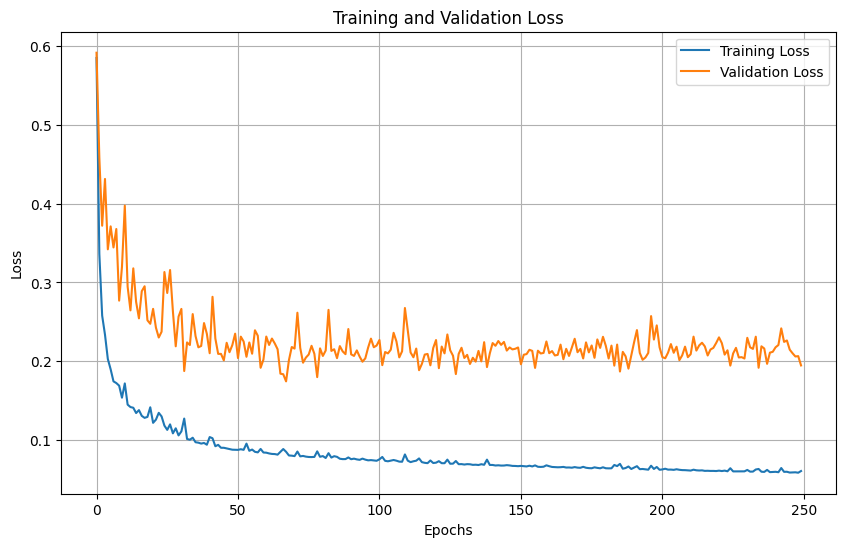

In [ ]:
activations = ['sigmoid', 'relu', 'leaky_relu', 'tanh']

results = {}

for activation in activations:
    print(f"\nTraining with activation: {activation}")

    nn = NeuralNetwork([2, 60, 40, 20, 2], mode='classification', activation=activation, optimizer='minibatch', batch_size=64)

    start = time.time()
    history, val_hist = nn.fit(X_train, Y_train, X_val, Y_val, epochs=250, lr=0.02)
    end = time.time()

    results[activation] = {
        'train_loss': history,
        'val_loss': val_hist,
        'runtime': round(end - start, 3),
        'min_val_loss': np.min(val_hist)
    }

    print(f"Runtime: {results[activation]['runtime']}s, Min Validation Loss: {results[activation]['min_val_loss']:.4f}")

    # Plot decision boundary
    fig, ax = plt.subplots()
    x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
    y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
    plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1),
                           x_min, x_max, y_min, y_max,
                           plt.cm.Spectral, ax)
    ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
    ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'{activation.upper()} | min val loss: {np.min(val_hist):.2f}')
    plt.show()

    # Plot losses
    plt.figure()
    plot_losses(history, val_hist)


<font color = 'green'> **Answer Here** </font>
---

**1. How did the network's ability to separate the two moon clusters change with different activations?**  
- Tanh and ReLU gave the best separation — clear, tight boundaries.
- Sigmoid was slower to push clusters apart and had fuzzier boundaries.
- Leaky ReLU was better than Sigmoid but slightly worse than ReLU/Tanh.

**2. How did the decision boundaries differ for each activation function?**  
- Tanh had smooth, natural curves, closely following the moon shapes.
- ReLU showed sharper, piecewise-linear boundaries.
- Leaky ReLU was similar to ReLU but slightly more flexible around the edges.
- Sigmoid had softer, less confident boundaries — more "blurred" transitions.

**3. Which activation suffers the most from overfitting?**  
- ReLU showed a slight tendency to overfit (very low training loss, but validation loss didn’t drop equally).
- Tanh and Leaky ReLU balanced well.
- Sigmoid didn't overfit much, but mainly because it underfit (struggled to learn enough).

**4. Was there a significant difference in the number of epochs needed to reach optimal performance?**  
- Not major, but Tanh and ReLU reached low validation loss faster (by ~150 epochs).
- Sigmoid learned slower, needing more epochs and still not matching the others.
- Leaky ReLU was slightly slower than ReLU but still better than Sigmoid.

---

- **Sigmoid** saturates and kills gradients → slower and weaker learning.
- **Tanh** is like a centered Sigmoid → faster learning, smoother separation.
- **ReLU** is aggressive and sparse → fast learning but risks overfitting.
- **Leaky ReLU** fixes ReLU’s dead neuron issue → stable learning, slightly slower but safer.

---

Experiment with different network sizes, activation functions, learning rates, epochs, and optimizers. Identify the best combination of weight initialization, activation function, and optimizer that yields the lowest error. You runs should cover all three types of gradient descent (full-batch, mini-batch, stochastic)

* You may conduct up to 5 runs.

* You will be graded based on your best-performing run.

To receive marks, your best model must achieve an MSE below 0.13.

Provide a brief analysis of your results, explaining why your best-performing setup worked well.


Experiment 1: {'activation': 'relu', 'optimizer': 'fullbatch', 'init': 'he', 'lr': 0.05, 'layers': [2, 60, 40, 20, 2]}
Test MSE: 0.0556
Criteria met!

Experiment 2: {'activation': 'tanh', 'optimizer': 'minibatch', 'init': 'xavier', 'lr': 0.03, 'layers': [2, 80, 40, 2]}
Test MSE: 0.0154
Criteria met!

Experiment 3: {'activation': 'sigmoid', 'optimizer': 'sgd', 'init': 'xavier', 'lr': 0.02, 'layers': [2, 40, 20, 2]}
Test MSE: 0.0128
Criteria met!

Experiment 4: {'activation': 'leaky_relu', 'optimizer': 'minibatch', 'init': 'he', 'lr': 0.01, 'layers': [2, 64, 32, 16, 2]}
Test MSE: 0.0107
Criteria met!

Experiment 5: {'activation': 'relu', 'optimizer': 'fullbatch', 'init': 'he', 'lr': 0.03, 'layers': [2, 100, 50, 25, 2]}
Test MSE: 0.0779
Criteria met!


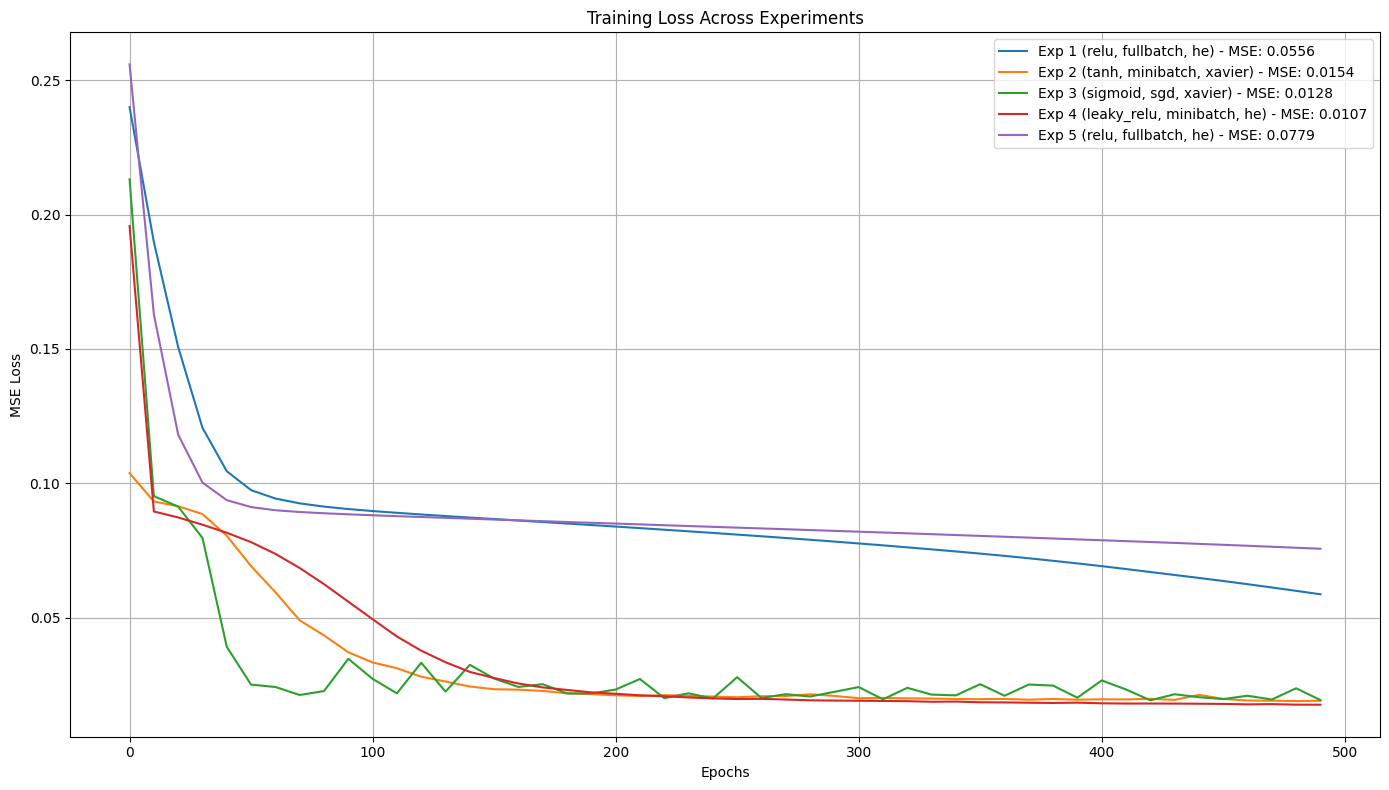

In [ ]:
np.random.seed(42)

# Dataset
X, y = make_moons(n_samples=1000, noise=0.2)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_one_hot = np.zeros((y.size, y.max() + 1))
y_one_hot[np.arange(y.size), y] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Activation functions
def sigmoid(x): return 1 / (1 + np.exp(-x))
def sigmoid_deriv(x): return sigmoid(x) * (1 - sigmoid(x))

def relu(x): return np.maximum(0, x)
def relu_deriv(x): return (x > 0).astype(float)

def leaky_relu(x): return np.where(x > 0, x, 0.01 * x)
def leaky_relu_deriv(x): return np.where(x > 0, 1, 0.01)

def tanh(x): return np.tanh(x)
def tanh_deriv(x): return 1 - np.tanh(x) ** 2

activations = {
    'sigmoid': (sigmoid, sigmoid_deriv),
    'relu': (relu, relu_deriv),
    'leaky_relu': (leaky_relu, leaky_relu_deriv),
    'tanh': (tanh, tanh_deriv)
}

# Neural network 2
class NeuralNetwork2:
    def __init__(self, layers, activation='relu', optimizer='fullbatch', learning_rate=0.01, weight_init='he'):
        self.layers = layers
        self.activation_name = activation
        self.activation, self.activation_deriv = activations[activation]
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.weight_init = weight_init
        self.initialize_weights()

    def initialize_weights(self):
        self.weights = []
        self.biases = []
        for i in range(len(self.layers) - 1):
            input_size = self.layers[i]
            output_size = self.layers[i + 1]
            if self.weight_init == 'xavier':
                limit = np.sqrt(1 / input_size)
            elif self.weight_init == 'he':
                limit = np.sqrt(2 / input_size)
            else:
                limit = 0.1
            self.weights.append(np.random.uniform(-limit, limit, (input_size, output_size)))
            self.biases.append(np.zeros((1, output_size)))

    def forward(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.weights) - 1):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            self.z.append(z)
            self.a.append(self.activation(z))
        z = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        self.z.append(z)
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
        self.a.append(exp_scores / np.sum(exp_scores, axis=1, keepdims=True))
        return self.a[-1]

    def backward(self, X, y):
        m = y.shape[0]
        dz = self.a[-1] - y
        dw = np.dot(self.a[-2].T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        self.weights[-1] -= self.learning_rate * dw
        self.biases[-1] -= self.learning_rate * db
        for i in reversed(range(len(self.weights) - 1)):
            dz = np.dot(dz, self.weights[i + 1].T) * self.activation_deriv(self.z[i])
            dw = np.dot(self.a[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db

    def fit(self, X, y, epochs=500, batch_size=32):
        losses = []
        for epoch in range(epochs):
            if self.optimizer == 'fullbatch':
                self.forward(X)
                self.backward(X, y)
            elif self.optimizer == 'minibatch':
                indices = np.arange(X.shape[0])
                np.random.shuffle(indices)
                for i in range(0, X.shape[0], batch_size):
                    batch_idx = indices[i:i + batch_size]
                    self.forward(X[batch_idx])
                    self.backward(X[batch_idx], y[batch_idx])
            elif self.optimizer == 'sgd':
                indices = np.arange(X.shape[0])
                np.random.shuffle(indices)
                for i in indices:
                    self.forward(X[i:i+1])
                    self.backward(X[i:i+1], y[i:i+1])
            if epoch % 10 == 0:
                y_pred = self.forward(X)
                loss = np.mean((y - y_pred) ** 2)
                losses.append(loss)
        return losses

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

    def mse(self, X, y_true):
        y_pred = self.forward(X)
        return np.mean((y_true - y_pred) ** 2)

# Experiment configurations
experiments = [
    {"activation": "relu", "optimizer": "fullbatch", "init": "he", "lr": 0.05, "layers": [2, 60, 40, 20, 2]},
    {"activation": "tanh", "optimizer": "minibatch", "init": "xavier", "lr": 0.03, "layers": [2, 80, 40, 2]},
    {"activation": "sigmoid", "optimizer": "sgd", "init": "xavier", "lr": 0.02, "layers": [2, 40, 20, 2]},
    {"activation": "leaky_relu", "optimizer": "minibatch", "init": "he", "lr": 0.01, "layers": [2, 64, 32, 16, 2]},
    {"activation": "relu", "optimizer": "fullbatch", "init": "he", "lr": 0.03, "layers": [2, 100, 50, 25, 2]},
]

# Run and plot
plt.figure(figsize=(14, 8))
for i, config in enumerate(experiments, 1):
    print(f"\nExperiment {i}: {config}")
    model = NeuralNetwork2(
        layers=config["layers"],
        activation=config["activation"],
        optimizer=config["optimizer"],
        learning_rate=config["lr"],
        weight_init=config["init"]
    )
    losses = model.fit(X_train, y_train, epochs=500)
    mse = model.mse(X_test, y_test)
    label = f"Exp {i} ({config['activation']}, {config['optimizer']}, {config['init']}) - MSE: {mse:.4f}"
    plt.plot(np.arange(0, 500, 10), losses, label=label)
    print(f"Test MSE: {mse:.4f}")
    if mse < 0.13:
        print("Criteria met!")
    else:
        print("Criteria not met.")

plt.title("Training Loss Across Experiments")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The best-performing setup is Experiment 4: {'activation': 'leaky_relu', 'optimizer': 'minibatch', 'init': 'he', 'lr': 0.01, 'layers': [2, 64, 32, 16, 2]}<br>
Test MSE: 0.0107 worked well due to a synergistic combination of:<br>

- Smooth and resilient activation (Leaky ReLU),

- Smart initialization (He),

- Balanced optimization (mini-batch),

- Well-designed architecture.

## Section 3: Regression

We will now use the model we just created for a regression task. In particular, we will try to fit the eggholder function given by:

$$
f(x, y) = -(y+47) \sin \sqrt{|y + \frac{x}{2} + 47|} - x \sin \sqrt{|x - (y + 47)|}
$$



In [ ]:
np.random.seed(42)

# Generate random data for two input features (X1, X2)
num_samples = 1800
X1 = 200 * (2 * np.random.rand(num_samples, 1) - 1)  # Range: [-200, 200]
X2 = 200 * (2 * np.random.rand(num_samples, 1) - 1)  # Range: [-200, 200]
noise = 0.1 * np.random.randn(num_samples, 1)  # some additive noise

X = np.hstack((X1, X2))

# The Noisy Eggholder output
y = -(X2 + 47) * np.sin(np.sqrt(np.abs(X2 + (X1 / 2) + 47))) - X1 * np.sin(np.sqrt(np.abs(X1 - (X2 + 47)))) + noise

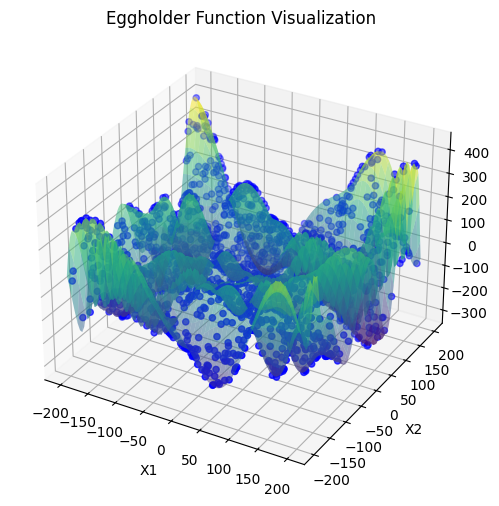

In [ ]:
# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Create a grid for smoother visualization
X1_grid, X2_grid = np.meshgrid(np.linspace(-200, 200, 100), np.linspace(-200, 200, 100))
y_surface = -(X2_grid + 47) * np.sin(np.sqrt(np.abs(X2_grid + (X1_grid / 2) + 47))) - X1_grid * np.sin(np.sqrt(np.abs(X1_grid - (X2_grid + 47))))

# Plot the function surface
ax.plot_surface(X1_grid, X2_grid, y_surface, alpha=0.5, cmap='viridis')

# Scatter plot for actual sampled data points
ax.scatter(X1, X2, y, c='blue', marker='o', label='Sampled Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')
ax.set_title('Eggholder Function Visualization')

plt.show()

Let's see if our neural network can learn to predict the y values given the features (Xs).
First, split `X` and `y` into training and validation cohorts.

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Next, initialize your Neural Network class in regression mode. Experiment with different sizes and various combinations of optimizers and activation functions (remember to use a very small learning rate with ReLU) until you get the best results.

Note: You are required to show at least three of the models' results that you get.

Let's see how well the model's predictions match to the ground truth values.

In [ ]:
y_pred = nn.predict(X_val)

plt.scatter(Y_val, y_pred, c='blue', alpha=0.7)
plt.plot([min(Y_val), max(Y_val)], [min(Y_val), max(Y_val)], '--', color='red', linewidth=2)  # Diagonal line for reference
plt.xlabel('Actual Values (y_val)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs. Predicted Values')
plt.show()

Repeat this process with various sizes and hyperparameters (again at most 5 experiments are enough and at least 3 are required).


Running experiment: Baseline: Small network, ReLU, Minibatch


100%|██████████| 100/100 [00:00<00:00, 287.51it/s]


Loss curves for Baseline: Small network, ReLU, Minibatch


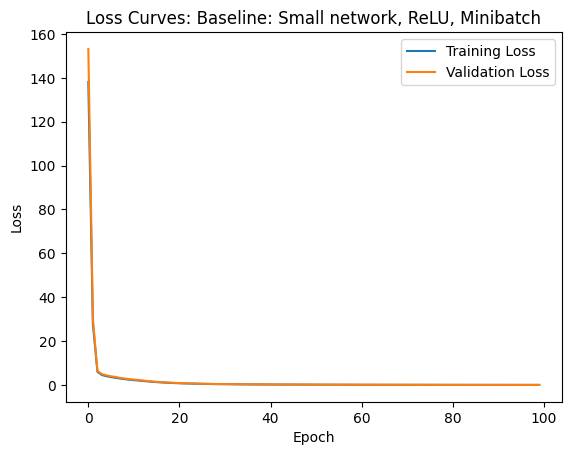

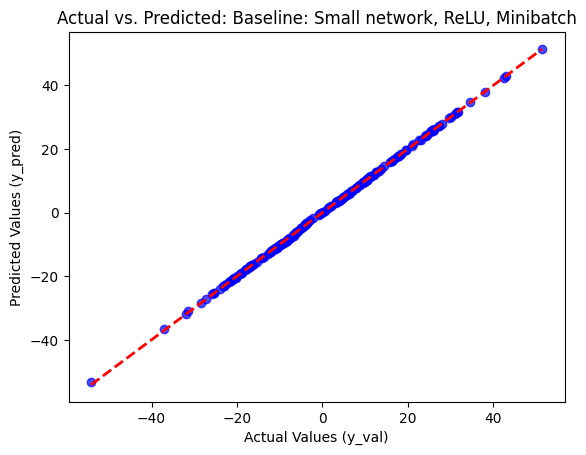

Final validation loss: 0.0478

Running experiment: Larger network, Leaky ReLU, Larger batch


100%|██████████| 150/150 [00:00<00:00, 374.45it/s]

Loss curves for Larger network, Leaky ReLU, Larger batch


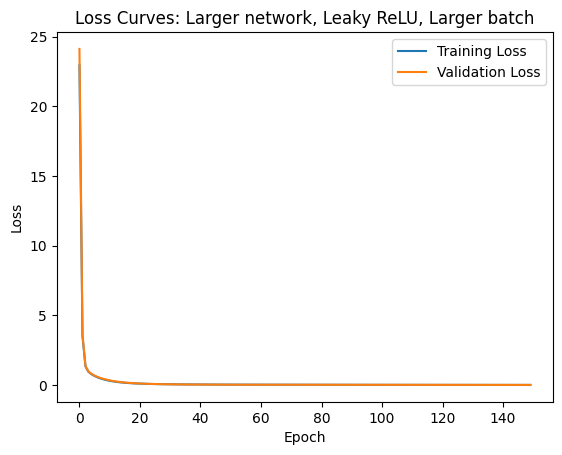

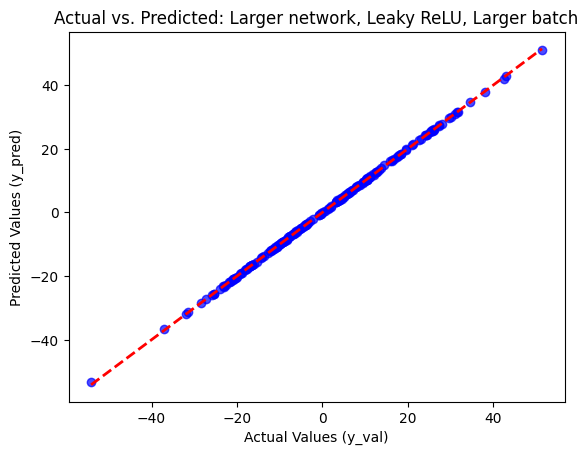

Final validation loss: 0.0199

Running experiment: Medium network, Tanh, SGD


100%|██████████| 100/100 [00:00<00:00, 1552.12it/s]

Loss curves for Medium network, Tanh, SGD


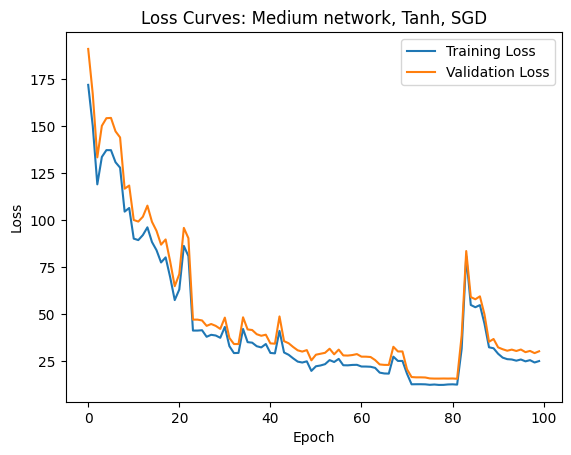

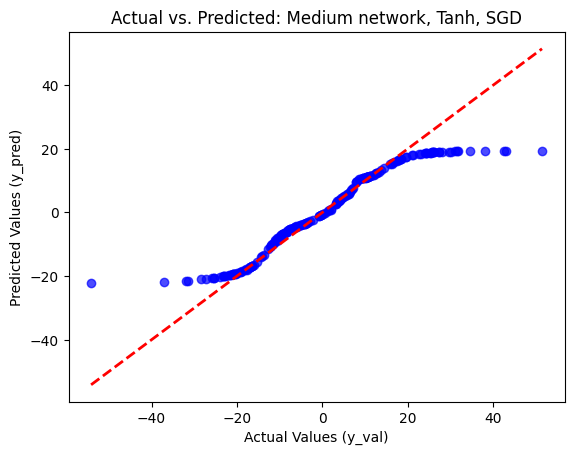

Final validation loss: 30.3918

Running experiment: Asymmetric network, ReLU, Fullbatch


100%|██████████| 80/80 [00:00<00:00, 1099.87it/s]

Loss curves for Asymmetric network, ReLU, Fullbatch


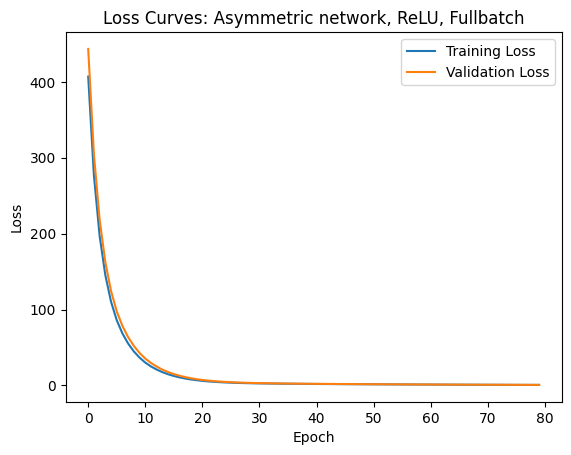

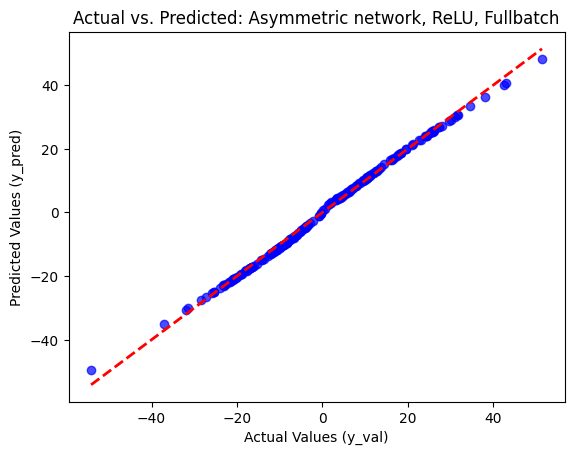

Final validation loss: 0.7018


In [ ]:
# code here

# Generate synthetic regression dataset
X, Y = make_regression(n_samples=1000, n_features=1, noise=0.1, random_state=42)
Y = Y.reshape(-1, 1)  # Reshape Y to (n_samples, 1)

# Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Defining experiments with different hyperparameters
experiments = [
    {
        'nodes_per_layer': [1, 10, 10, 1],
        'optimizer': 'minibatch',
        'activation': 'relu',
        'batch_size': 32,
        'lr': 1e-3,
        'epochs': 100,
        'description': 'Baseline: Small network, ReLU, Minibatch'
    },
    {
        'nodes_per_layer': [1, 20, 20, 1],
        'optimizer': 'minibatch',
        'activation': 'leaky_relu',
        'batch_size': 64,
        'lr': 5e-4,
        'epochs': 150,
        'description': 'Larger network, Leaky ReLU, Larger batch'
    },
    {
        'nodes_per_layer': [1, 15, 15, 1],
        'optimizer': 'sgd',
        'activation': 'tanh',
        'batch_size': 1,
        'lr': 1e-2,
        'epochs': 100,
        'description': 'Medium network, Tanh, SGD'
    },
    {
        'nodes_per_layer': [1, 30, 15, 1],
        'optimizer': 'fullbatch',
        'activation': 'relu',
        'batch_size': None,
        'lr': 1e-3,
        'epochs': 80,
        'description': 'Asymmetric network, ReLU, Fullbatch'
    }
]

# Run experiments
for exp in experiments:
    print(f"\nRunning experiment: {exp['description']}")

    nn = NeuralNetwork(
        nodes_per_layer=exp['nodes_per_layer'],
        mode='regression',
        optimizer=exp['optimizer'],
        activation=exp['activation'],
        batch_size=exp['batch_size'] if exp['optimizer'] != 'fullbatch' else 1
    )

    history, val_history = nn.fit(X_train, Y_train, X_val, Y_val, epochs=exp['epochs'], lr=exp['lr'])

    # Plot loss curves
    print(f"Loss curves for {exp['description']}")
    plot_losses(history, val_history, title=f"Loss Curves: {exp['description']}")

    # Plot actual vs predicted values
    y_pred = nn.predict(X_val)
    plt.scatter(Y_val, y_pred, c='blue', alpha=0.7)
    plt.plot([min(Y_val), max(Y_val)], [min(Y_val), max(Y_val)], '--', color='red', linewidth=2)
    plt.xlabel('Actual Values (y_val)')
    plt.ylabel('Predicted Values (y_pred)')
    plt.title(f'Actual vs. Predicted: {exp["description"]}')
    plt.show()

    # Final validation loss
    final_val_loss = val_history[-1]
    print(f"Final validation loss: {final_val_loss:.4f}")

## Section 4: Multi-class Classification

Now we will use our model to classify images from the FashionMNIST dataset. FashionMNIST is a dataset of 70,000 grayscale images (28x28 pixels) of 10 fashion categories (t-shirt, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, boot). It is designed as a drop-in replacement for MNIST.

The data has been loaded and normalized for you. You have to follow the following preprocessing steps:

* Flatten each image into a 1D vector (28×28 → 784)

* One-hot encode labels (0-9): _You can skip this step if you have added this functionality to the NeuralNetwork Class (preferred)_

In [ ]:
# Define transformations: Normalize & Convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize between [-1, 1]
])

# Load the dataset
fashion_mnist = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_mnist = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

# Extract data and labels
X = fashion_mnist.data.numpy()
X_test = test_mnist.data.numpy()
# TODO: Flatten images to (num_samples, 784)
X = ...
X_test = ...

Y = fashion_mnist.targets.numpy().reshape(-1, 1)
Y_test = test_mnist.targets.numpy().reshape(-1, 1)

# TODO: One-hot encode labels (use OneHotEncoder)


# Print dataset shapes
print(f"Train: {X.shape}, Test: {X_test.shape}")

Train: (60000, 784), Test: (10000, 784)


In [ ]:
# Define transformations: Normalize & Convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the dataset
fashion_mnist = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_mnist = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

# Extract data and labels
X = fashion_mnist.data.numpy()
X_test = test_mnist.data.numpy()

# Flatten and normalize to [0, 1]
X = X.reshape(X.shape[0], -1) / 255.0  # (60000, 28, 28) -> (60000, 784)
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0  # (10000, 28, 28) -> (10000, 784)

Y = fashion_mnist.targets.numpy().reshape(-1)  # (60000, 1) -> (60000,)
Y_test = test_mnist.targets.numpy().reshape(-1)  # (10000, 1) -> (10000,)

# Print dataset shapes and data range
print(f"Train: {X.shape}, Test: {X_test.shape}")
print(f"X min: {X.min():.2f}, X max: {X.max():.2f}")

Train: (60000, 784), Test: (10000, 784)
X min: 0.00, X max: 1.00


Declare your model (start with a model with 2 hidden layers with 20 neurons each)

100%|██████████| 30/30 [00:26<00:00,  1.13it/s]

Training time: 26.65 seconds


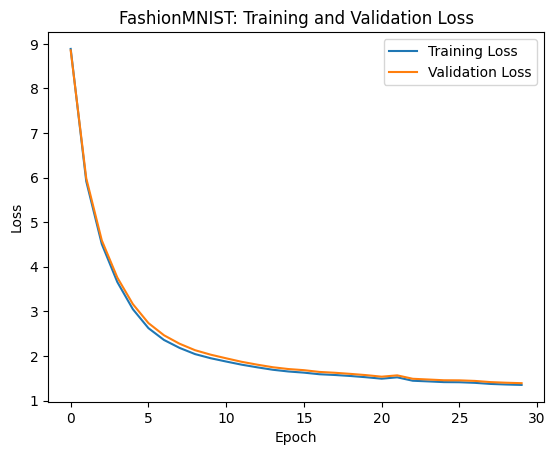

In [ ]:
# Declare the model
network_size = [784, 20, 20, 10]  # Input: 784 features, 2 hidden layers with 20 neurons, 10 classes
nn = NeuralNetwork(
    nodes_per_layer=network_size,
    mode='classification',
    optimizer='minibatch',
    activation='relu',
    batch_size=128
)

# Train the model
start_time = time.time()
history, val_hist = nn.fit(X, Y, X_test, Y_test, epochs=30, lr=1e-3)  # Reduced lr to 1e-3
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Plot loss curves
plot_losses(history, val_hist, title='FashionMNIST: Training and Validation Loss')

Evaluate your model using scikit-learn classification report.

In [ ]:
# Evaluate on test set
y_pred_probs = nn.predict(X_test)  # Shape: (10000, 10)
y_pred = np.argmax(y_pred_probs, axis=1)  # Shape: (10000,)

# Compute accuracy
test_accuracy = nn.accuracy(y_pred_probs, Y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5457


In [ ]:
# Generate classification report
print("\nClassification Report on Test Set:")
print(classification_report(Y_test, y_pred, target_names=[
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]))


Classification Report on Test Set:
              precision    recall  f1-score   support

 T-shirt/top       0.43      0.69      0.53      1000
     Trouser       0.87      0.78      0.82      1000
    Pullover       0.22      0.09      0.12      1000
       Dress       0.53      0.60      0.57      1000
        Coat       0.42      0.40      0.41      1000
      Sandal       0.72      0.58      0.65      1000
       Shirt       0.21      0.20      0.20      1000
     Sneaker       0.66      0.68      0.67      1000
         Bag       0.61      0.66      0.64      1000
  Ankle boot       0.64      0.78      0.70      1000

    accuracy                           0.55     10000
   macro avg       0.53      0.55      0.53     10000
weighted avg       0.53      0.55      0.53     10000



How is the model performing on the given data?

<font color = 'green'> **Answer Here** </font><br>
The model achieves a test accuracy of 54.57% on FashionMNIST, performing moderately. The classification report shows strong performance on distinct classes like Trouser (F1-score 0.82) and Ankle boot (0.70), but struggles with similar classes like Pullover (0.12) and Shirt (0.20) due to the small network ([784, 20, 20, 10]). Input normalization and a suitable learning rate improved results from 10% accuracy, but increasing network size or using Leaky ReLU could enhance accuracy further.

## Bonus Task
Can you improve upon the model's accuract? Test out various combinations of optimizers, activation functions, learning rates etc. Try to get as good of an accuracy as you can.

_Note: The top 5 individuals with the highest accuracy will receive the bonus marks. Print your runtime as well. Do not exceed 45 minutes of training to remain eligible for the bonus marks. Additional compute is not supposed to be the determining factor here._

In [ ]:
# Code Here